In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train = pd.read_csv("data/numerai_training_data.csv")

In [3]:
train.describe()

,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,...,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
count,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,...,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000,501808.000000
mean,0.499981,0.499979,0.499979,0.499981,0.499977,0.499977,0.499977,0.499981,0.499980,0.499980,...,0.499982,0.499982,0.499974,0.499980,0.499982,0.499980,0.499974,0.499979,0.499971,0.499997
std,0.353596,0.353593,0.353593,0.353596,0.353587,0.353587,0.353587,0.353596,0.352099,0.352099,...,0.353139,0.353139,0.351328,0.350662,0.352151,0.352965,0.351328,0.347689,0.353419,0.223268
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,...,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.500000
50%,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,...,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000
75%,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,...,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.750000,0.500000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [4]:
intelligence = train.columns[train.columns.str.startswith('feature_intelligence')].values.tolist()
target = train["target"]

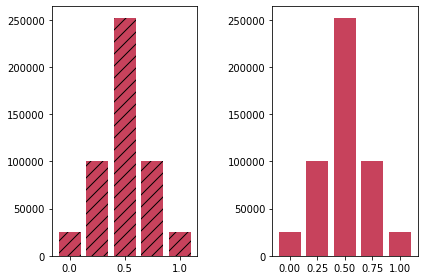

In [100]:
fig, (ax1, ax2) = plt.subplots(1, 2)

labels, counts = np.unique(target, return_counts=True)

ax1.bar(labels,counts,align="center",width=0.2,hatch='//', color=np.array((199, 66, 92))/255)
plt.gca().set_xticks(labels)


ax2.bar(labels,counts,align="center",width=0.2, color=np.array((199, 66, 92))/255)
plt.gca().set_xticks(labels)


plt.tight_layout(w_pad=3)
plt.show()

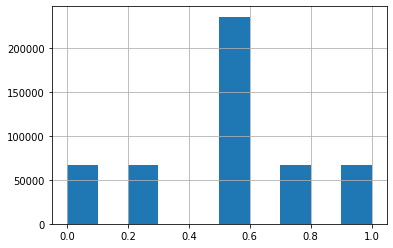

In [76]:
train.feature_charisma22.hist(x)

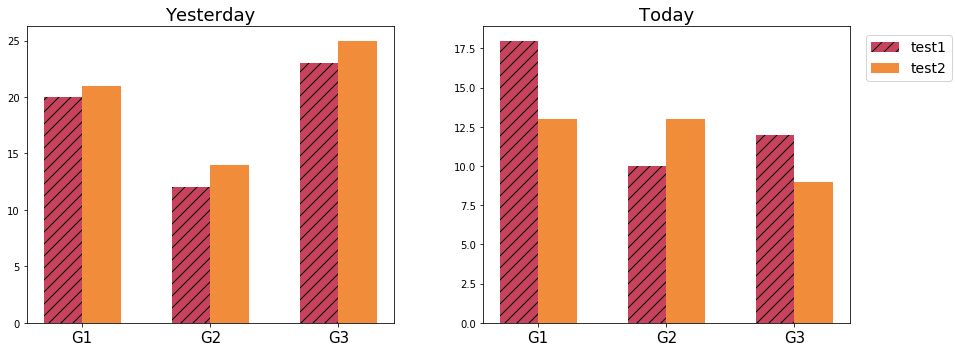

In [89]:
labels = ['G1', 'G2', 'G3']
yesterday_test1_mean = [20, 12, 23]
yesterday_test2_mean = [21, 14, 25]
today_test1_mean = [18, 10, 12]
today_test2_mean = [13, 13, 9]

x = np.arange(len(labels))
width = 0.3

plt.figure(figsize=(12,5))

plt.subplot(121)
plt.title('Yesterday', fontsize=18)
plt.bar(x-width/2, yesterday_test1_mean, width, label='test1', hatch='//', color=np.array((199, 66, 92))/255)
plt.bar(x+width/2, yesterday_test2_mean, width, label='test2', color=np.array((240, 140, 58))/255)
plt.xticks([0,1,2], labels, fontsize=15)


plt.subplot(122)
plt.title('Today', fontsize=18)
plt.bar(x-width/2, today_test1_mean, width, hatch='//', color=np.array((199, 66, 92))/255)
plt.bar(x+width/2, today_test2_mean, width, color=np.array((240, 140, 58))/255)
plt.xticks([0,1,2], labels, fontsize=15)

plt.figlegend(loc='upper right', ncol=1, labelspacing=0.5, fontsize=14, bbox_to_anchor=(1.11, 0.9))
plt.tight_layout(w_pad=6)
plt.show()